In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

df = pd.read_csv('../data/movies_database.csv', na_values=['#EMPTY?'], delimiter=";")


#remove nulls and duplicates
df = df.dropna(subset="Description")
df = df.drop_duplicates(subset="Description")


# one hot enconding
dummies = df["Genre(s)"].str.get_dummies(sep=",")
df = pd.concat([df, dummies], axis=1)


# Combine as colunas 'Description' e 'Keywords'
df['Combined'] = df['Description'] + ' ' + df['Keywords'].astype(str)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df.drop(['Date Published','Rating','Rating Count','Content Rating','Genre(s)','Keywords'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 0 to 24579
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         8224 non-null   object
 1   Description  8224 non-null   object
 2   Action       8224 non-null   int64 
 3   Adult        8224 non-null   int64 
 4   Adventure    8224 non-null   int64 
 5   Animation    8224 non-null   int64 
 6   Biography    8224 non-null   int64 
 7   Comedy       8224 non-null   int64 
 8   Crime        8224 non-null   int64 
 9   Documentary  8224 non-null   int64 
 10  Drama        8224 non-null   int64 
 11  Family       8224 non-null   int64 
 12  Fantasy      8224 non-null   int64 
 13  Film-Noir    8224 non-null   int64 
 14  History      8224 non-null   int64 
 15  Horror       8224 non-null   int64 
 16  Music        8224 non-null   int64 
 17  Musical      8224 non-null   int64 
 18  Mystery      8224 non-null   int64 
 19  News         8224 non-null

<AxesSubplot:>

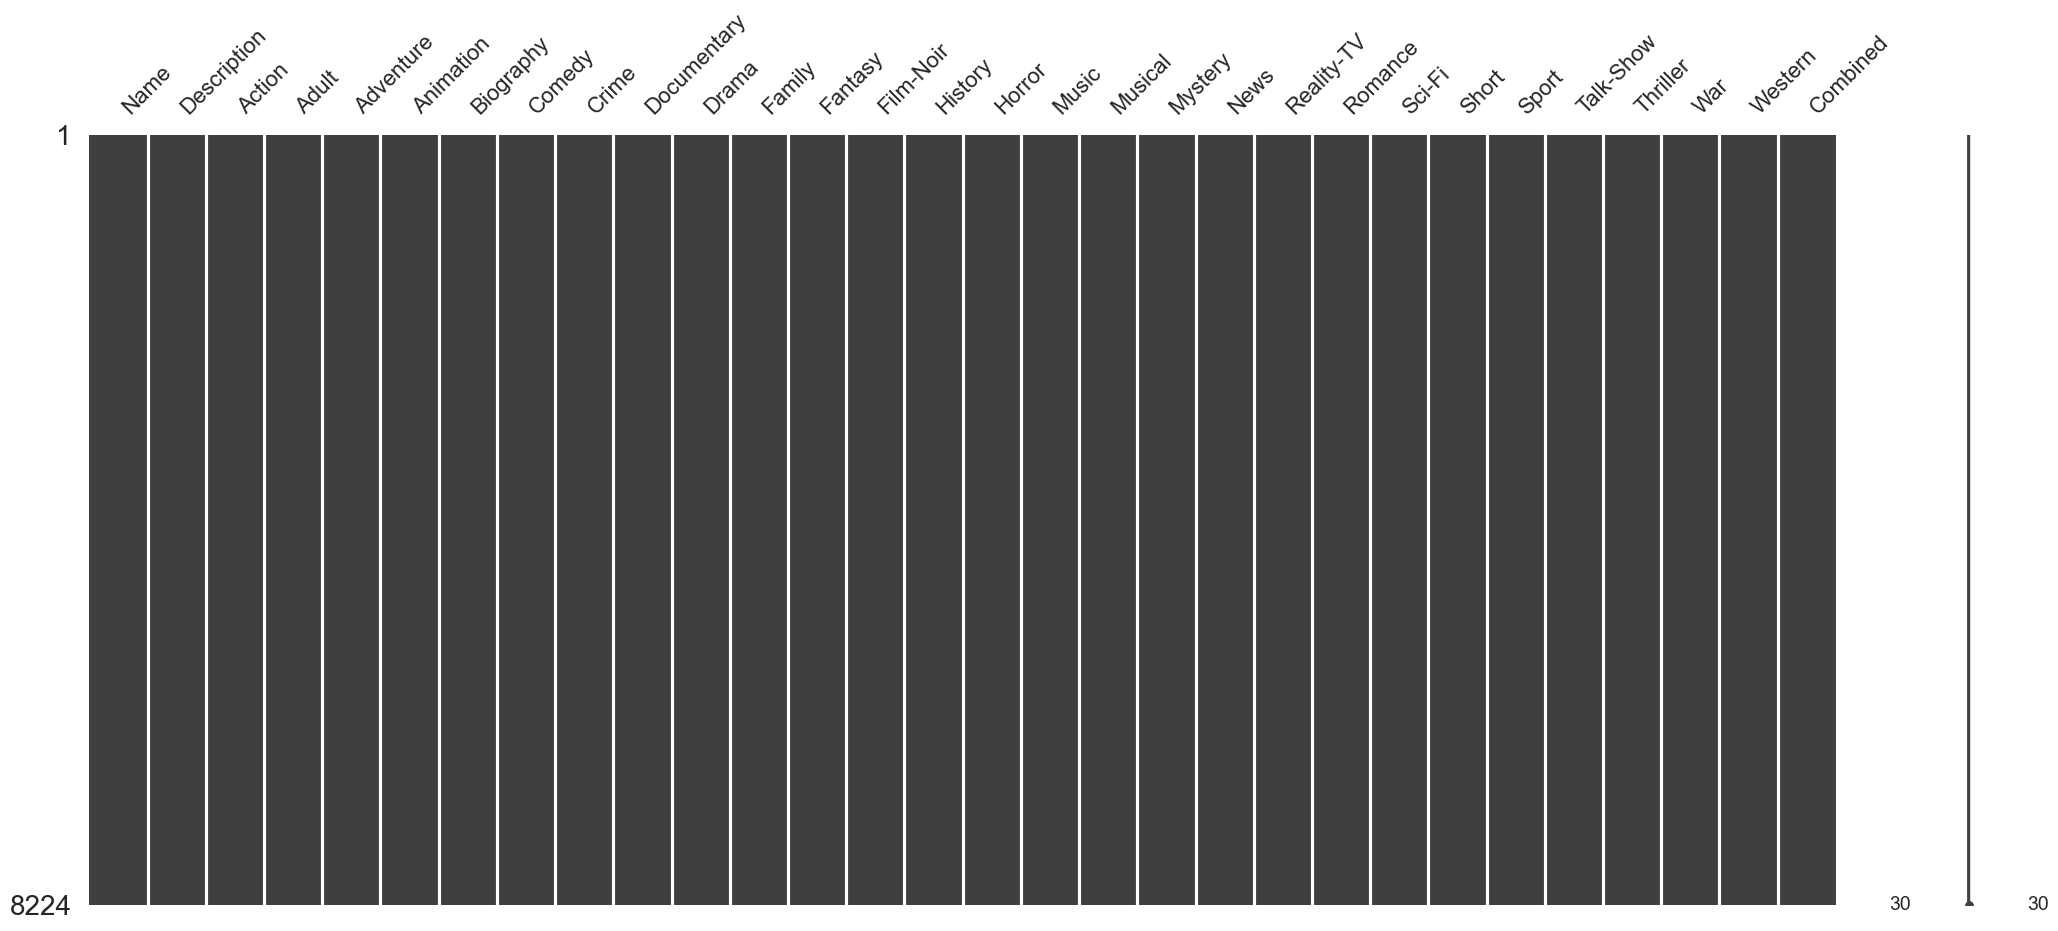

In [3]:

import missingno as msno
# identificação de dados ausentes
msno.matrix(df)

In [4]:
category_columns = df.columns.drop(['Name', 'Description', 'Combined'])
for col in category_columns:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 0 to 24579
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         8224 non-null   object  
 1   Description  8224 non-null   object  
 2   Action       8224 non-null   category
 3   Adult        8224 non-null   category
 4   Adventure    8224 non-null   category
 5   Animation    8224 non-null   category
 6   Biography    8224 non-null   category
 7   Comedy       8224 non-null   category
 8   Crime        8224 non-null   category
 9   Documentary  8224 non-null   category
 10  Drama        8224 non-null   category
 11  Family       8224 non-null   category
 12  Fantasy      8224 non-null   category
 13  Film-Noir    8224 non-null   category
 14  History      8224 non-null   category
 15  Horror       8224 non-null   category
 16  Music        8224 non-null   category
 17  Musical      8224 non-null   category
 18  Mystery      8224 non-null 

In [5]:
sum_genre = df[category_columns].astype(int).sum()
df_movies_per_genre = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre})

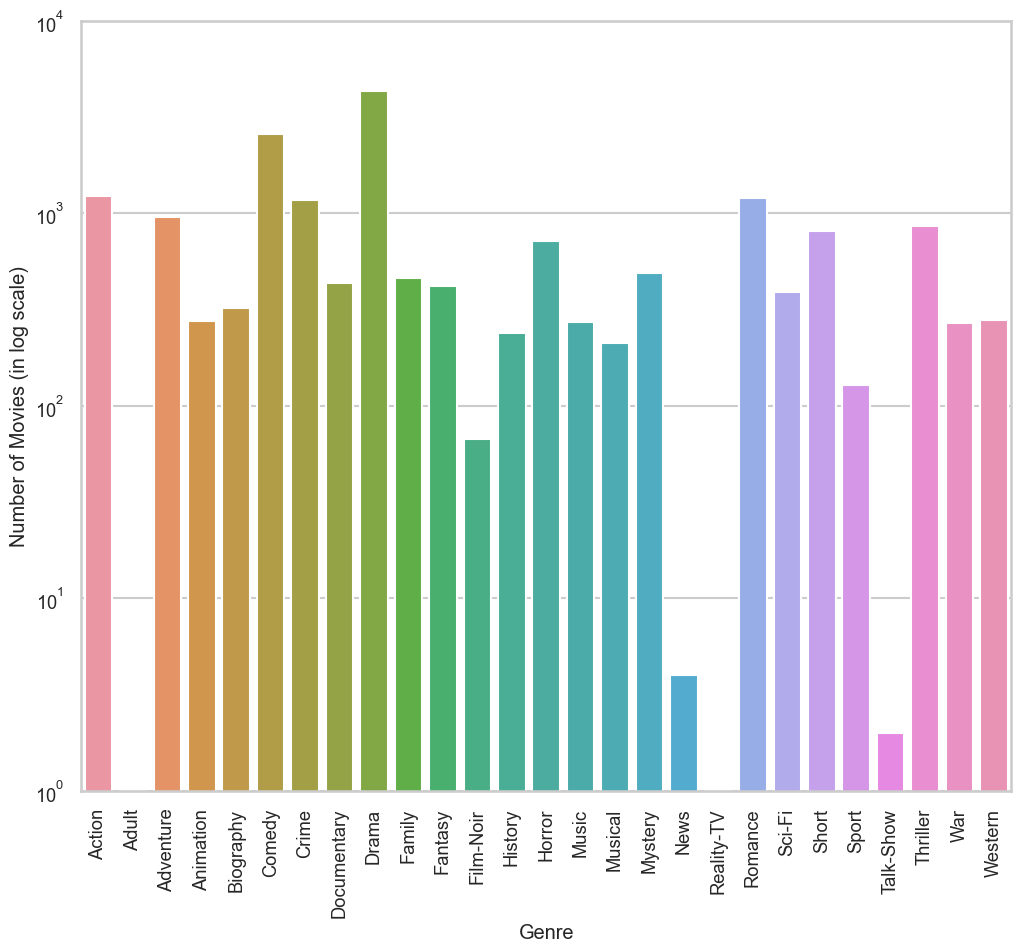

In [6]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(yscale='log', ylim=(1, 1e4), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

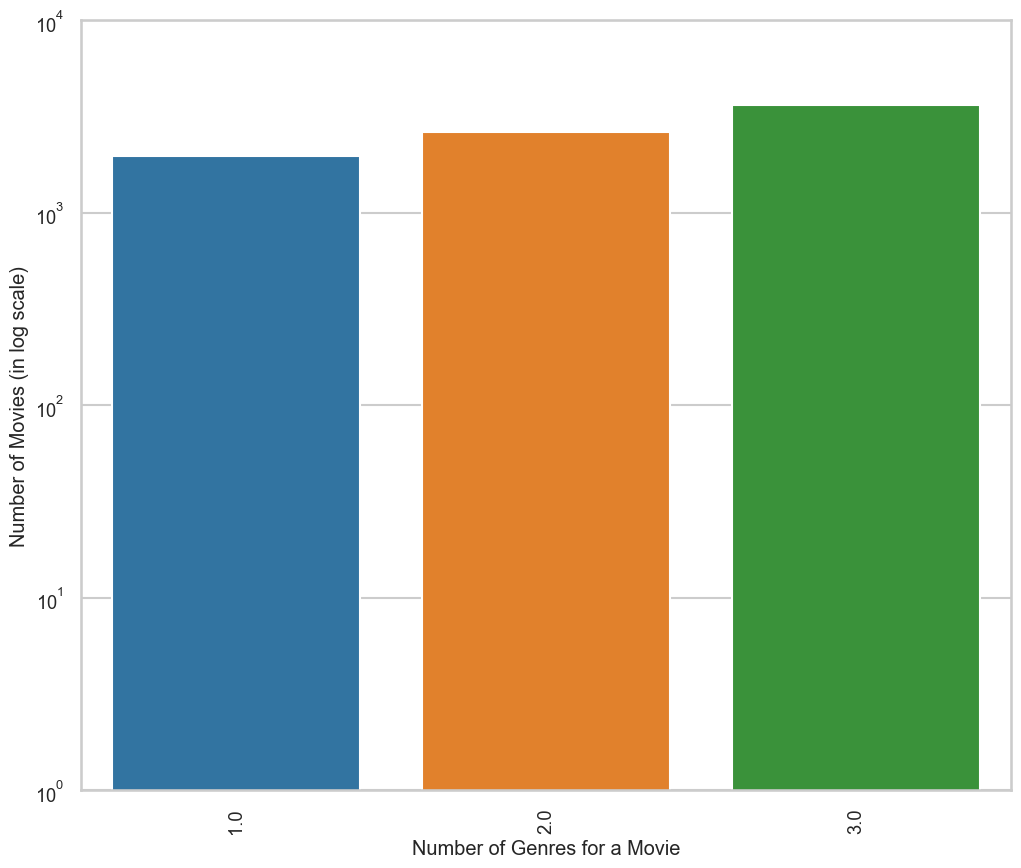

In [7]:
sum_movie = df[category_columns].sum(axis=1)
df_genres_per_movie = pd.DataFrame({'title': df.Name, 'num_genres':sum_movie}).groupby('num_genres').count()
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='title', axes=ax)
ax.set(yscale='log', ylim=(1, 1e4), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

In [8]:
print('On an average, movies are classified into {0:.2f} genres'.format(sum_movie.mean()))
print('Number of movies with 3 genres = {0}'.format(len(sum_movie[sum_movie==3])))

On an average, movies are classified into 2.20 genres
Number of movies with 3 genres = 3621


In [36]:
df[category_columns].astype(int).sum()


Action         1235
Adult             1
Adventure       955
Animation       277
Biography       321
Comedy         2574
Crime          1176
Documentary     436
Drama          4303
Family          463
Fantasy         418
Film-Noir        67
History         240
Horror          718
Music           273
Musical         212
Mystery         492
News              4
Reality-TV        1
Romance        1203
Sci-Fi          390
Short           805
Sport           128
Talk-Show         2
Thriller        854
War             269
Western         279
dtype: int64

In [37]:
# remove movies with insignificant representation data (under de 200 entries)- Adult, Film-Noir, News, Reality TV, Talk Show,Sport
genres_to_remove = ['Adult', 'Film-Noir', 'News', 'Reality-TV', 'Talk-Show','Sport'];
entries_to_remove = df.loc[(df[genres_to_remove] == 1).any(axis=1)]

df = df.drop(entries_to_remove.index, axis=0)
df.drop(genres_to_remove, axis=1, inplace=True)

In [43]:
category_columns = category_columns.drop(['Adult', 'Film-Noir', 'News', 'Reality-TV', 'Talk-Show','Sport'])
df[category_columns].astype(int).sum()

Action         1228
Adventure       952
Animation       277
Biography       308
Comedy         2534
Crime          1116
Documentary     417
Drama          4170
Family          452
Fantasy         417
History         238
Horror          718
Music           272
Musical         208
Mystery         484
Romance        1185
Sci-Fi          389
Short           802
Thriller        845
War             268
Western         279
dtype: int64

In [44]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

In [45]:
def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

In [46]:
def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

In [47]:
def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

In [48]:
def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

In [49]:
def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

In [50]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within','apos'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

In [51]:
def text_preprocess(sentence):
    pre_processed_sentence = remove_accents(sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

In [52]:
df['Combined'] = df['Combined'].apply(text_preprocess)
df.to_csv('../data/movies_genres_preprocessed.csv', index=False)


In [21]:
##word cloud
def save_wordcloud_plots(data, labels):
    for idx, col in enumerate(labels):
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(data[data[col]==1]['Combined']))
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        plt.savefig('../images/results/wordcloud_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_wordcloud_subplots(data, labels):
    num_plot = 3
    fig_per_plot = math.ceil(len(category_columns)/num_plot)
    num_cols = 2
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(14, 20))
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(df[df[col]==1]['Combined']))
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('../images/results/wordcloud_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(14, 20))

In [22]:
if not os.path.exists('images/results/wordcloud_Action.png'):
    save_wordcloud_plots(df, category_columns)
if not os.path.exists('images/results/wordcloud_part1.png'):
    save_wordcloud_subplots(df, category_columns)

<Figure size 1400x2000 with 0 Axes>

<Figure size 1400x2000 with 0 Axes>

<Figure size 1400x2000 with 0 Axes>

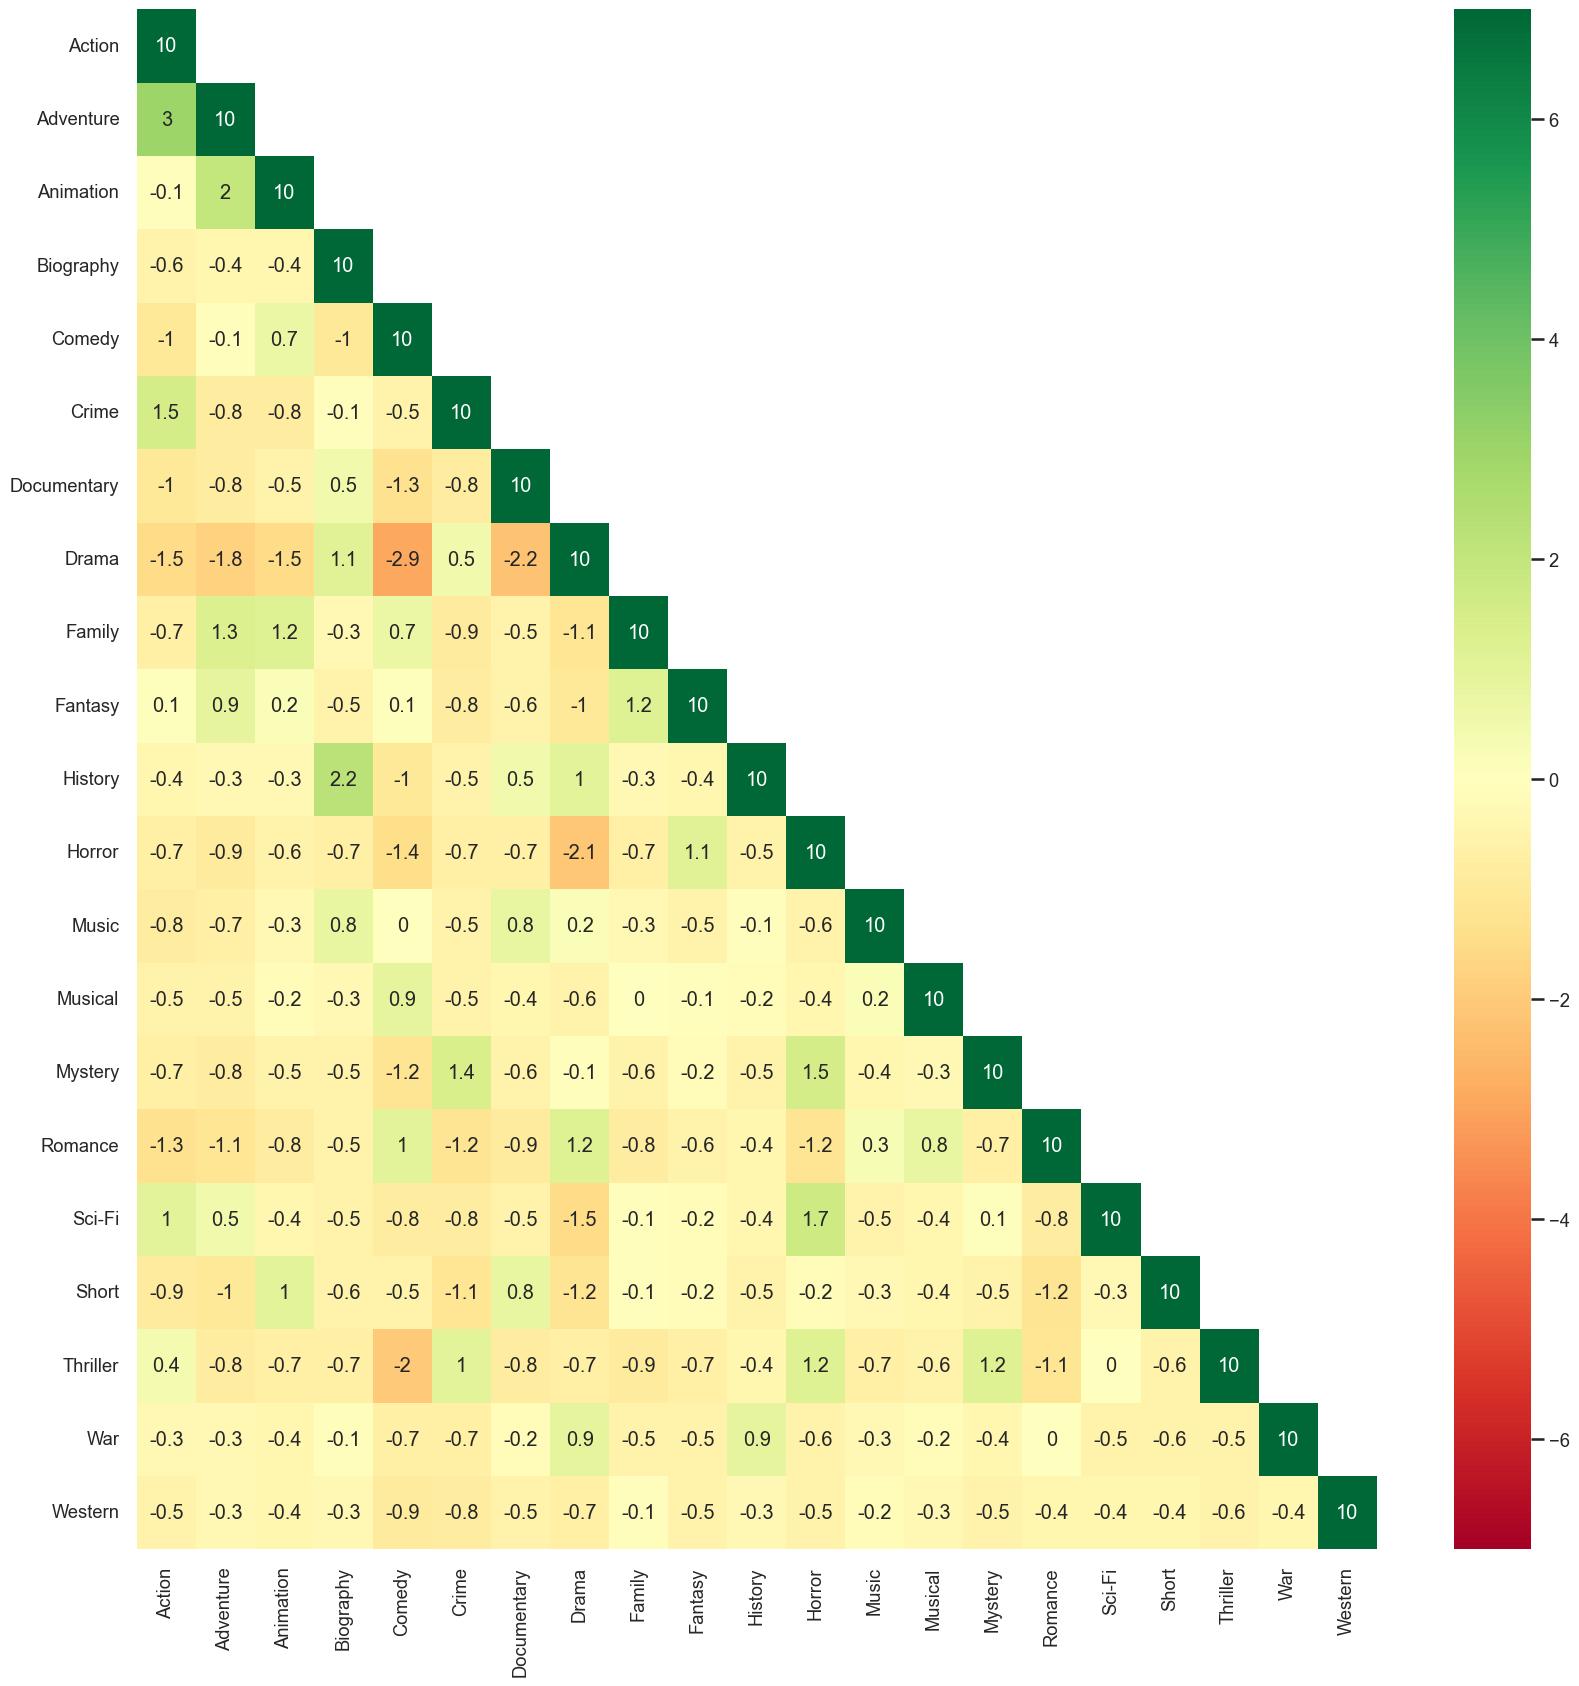

In [53]:
# Heatmap relative to all numeric columns
corr_matrix = (df[category_columns].astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
plt.show()

In [107]:
## test train split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import math

def multi_label_train_test_split(data, labels, test_size=0.15, n_splits=10, random_state=29):
    best_train = None
    best_test = None
    best_ratio = 0

    for _ in range(n_splits):
        data_train = data.copy()
        data_test = pd.DataFrame(columns=data.columns)

        for col in labels:
            # Extracting the current genre plots
            data_curr_genre = data_train[data_train[col] == 1]

            # Split the current genre data
            curr_train, curr_test = train_test_split(data_curr_genre, test_size=test_size, random_state=random_state)

            # Update data_train and data_test
            data_train = data_train.drop(curr_test.index)
            data_test = pd.concat([data_test, curr_test])

        data_train = data_train.reset_index(drop=True)
        data_test = data_test.reset_index(drop=True)
        ratio = len(data_train) / len(data)

        if abs(ratio - (1 - test_size)) < abs(best_ratio - (1 - test_size)):
            best_train = data_train
            best_test = data_test
            best_ratio = ratio

    return best_train, best_test

In [108]:
    mydata_raw = pd.read_csv('../data/movies_genres_preprocessed.csv')
    min_test_size = 0.185
    mydata_train, mydata_test = multi_label_train_test_split(mydata_raw, category_columns, test_size=min_test_size)

In [109]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(mydata_test.shape[0]/df.shape[0]))

Fraction of data in the Training Data Set: 0.354


In [110]:
sum_genre = df[category_columns].astype(int).sum()
sum_genre_train = mydata_train[category_columns].astype(int).sum()
sum_genre_test = mydata_test[category_columns].astype(int).sum()
df_movies_per_genre_1 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_train/sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_2 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_test/sum_genre, 'Data Set': 'Test'})
df_movies_per_genre = pd.concat([df_movies_per_genre_1, df_movies_per_genre_2])

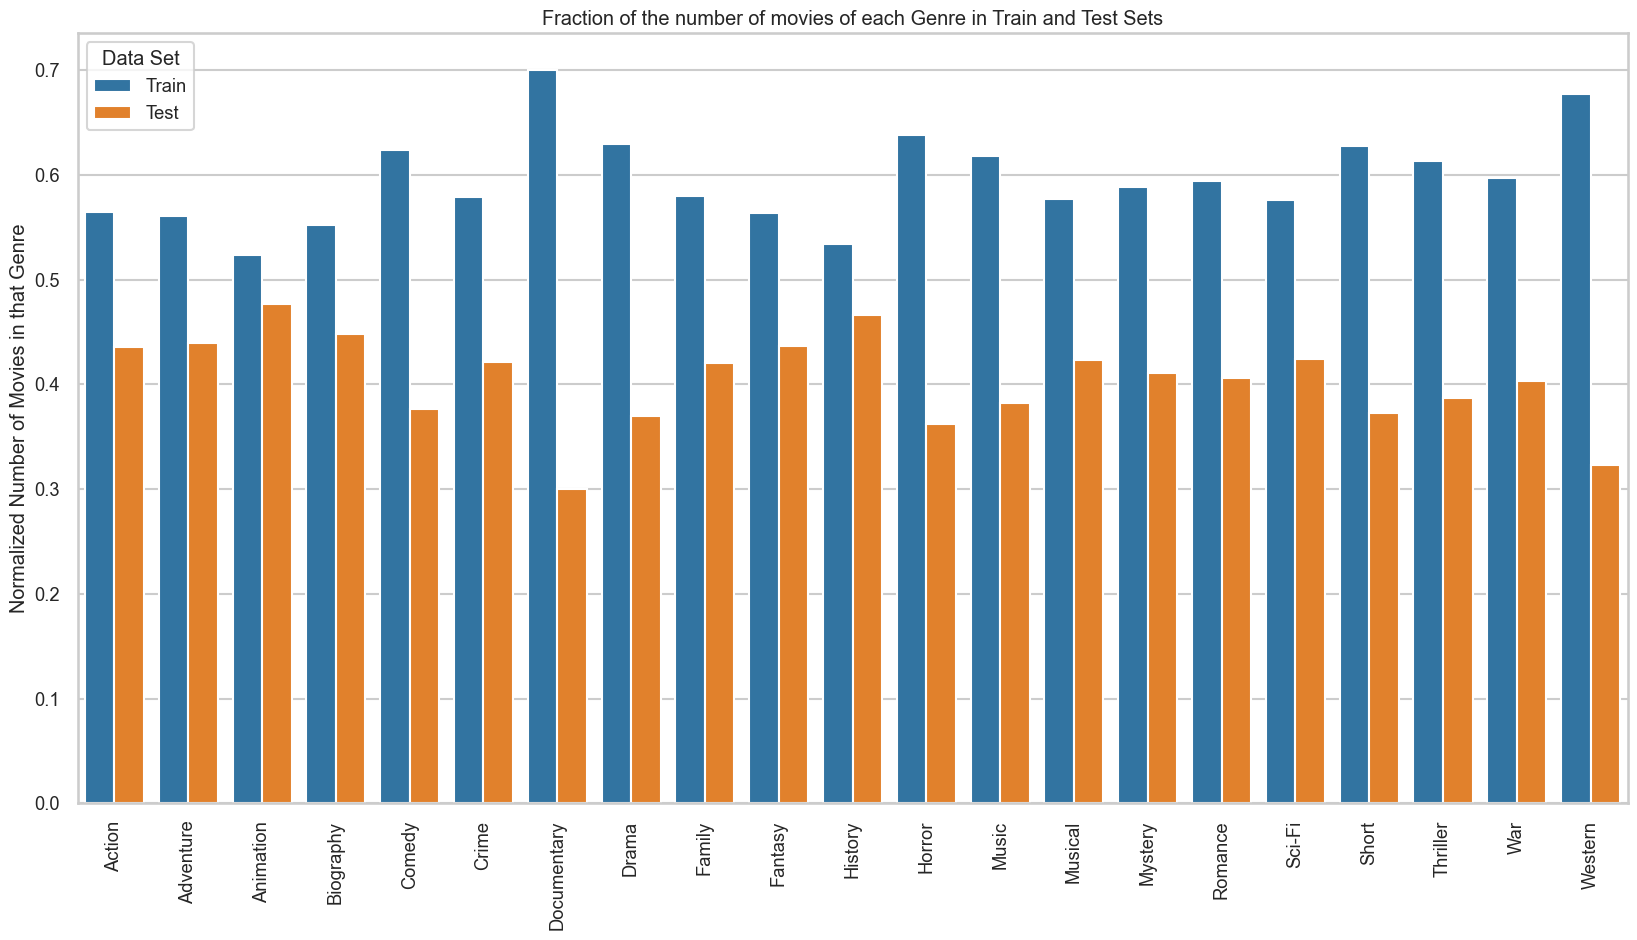

In [111]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Movies in that Genre', xlabel='')
ax.set(title='Fraction of the number of movies of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

In [112]:
mydata_train.to_csv('../data/preprocessed/movies_genres_train_preprocessed.csv', index=False)
mydata_test.to_csv('../data/preprocessed/movies_genres_test_preprocessed.csv', index=False)